# Coursework Notebook: Regularisation in Neural Networks

**Author:** Aniket Mane  
**Student ID:** 23096043

This notebook contains the full code used to train, evaluate, and visualise the neural network models discussed in the coursework tutorial. All experiments, figures, and results presented in the PDF tutorial were generated using this notebook.

**GitHub Repository:**  
https://github.com/aniket12341/Regularisation_assignment


In [6]:
# Step 1: Set up the notebook environment
# ---------------------------------------
# Import the core libraries we’ll need for training neural networks,
# loading the dataset, and creating our plots.

import os
import math
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Create a folder for saving plots later on.
os.makedirs("figures", exist_ok=True)

# Fix the random seeds so results are reproducible.
torch.manual_seed(42)
np.random.seed(42)

# Select the appropriate device (GPU if available, otherwise CPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [7]:
# Step 2: Load and prepare the Fashion-MNIST dataset
# ---------------------------------------------------
# We download Fashion-MNIST, then carve out a smaller subset:
# - 5,000 examples for training
# - 1,000 examples for validation
# - full 10,000 examples for testing

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Transform:
# 1) Convert images to tensors
# 2) Normalize pixel values to roughly [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data_root = "./data"

# Full training set (60,000 images)
train_full = datasets.FashionMNIST(
    root=data_root,
    train=True,
    download=True,
    transform=transform
)

# Test set (10,000 images)
test_dataset = datasets.FashionMNIST(
    root=data_root,
    train=False,
    download=True,
    transform=transform
)

class_names = train_full.classes
print("Classes:", class_names)
print("Total training samples:", len(train_full))

# We will only use a subset for faster experiments: 6,000 total
# 5,000 for training, 1,000 for validation.
subset_size = 6000
train_size = 5000
val_size = subset_size - train_size

train_subset, _ = random_split(
    train_full,
    [subset_size, len(train_full) - subset_size],
    generator=torch.Generator().manual_seed(42)
)

train_dataset, val_dataset = random_split(
    train_subset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print("Train subset size:", len(train_dataset))
print("Validation subset size:", len(val_dataset))
print("Test set size:", len(test_dataset))

# Set up data loaders
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=256, shuffle=False)


100.0%
100.0%
100.0%
100.0%


Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Total training samples: 60000
Train subset size: 5000
Validation subset size: 1000
Test set size: 10000


In [9]:
# Step 3: Define the neural network model
# ---------------------------------------
# We build a straightforward multilayer perceptron (MLP) with:
# - Two hidden layers (256 and 128 units)
# - ReLU activations
# - Optional dropout in the hidden layers
#
# The same model class will be reused for all experiments.
# We will only change the dropout probability and the optimiser settings.

class RegularisedMLP(nn.Module):
    def __init__(
        self,
        input_dim=28 * 28,
        hidden_sizes=[256, 128],
        num_classes=10,
        dropout_p=0.0
    ):
        super().__init__()

        layers = []
        last_dim = input_dim

        for hidden_dim in hidden_sizes:
            # Linear layer
            layers.append(nn.Linear(last_dim, hidden_dim))
            # Non-linear activation
            layers.append(nn.ReLU())
            # Optional dropout
            if dropout_p > 0.0:
                layers.append(nn.Dropout(dropout_p))

            last_dim = hidden_dim

        # Final layer that maps to 10 class logits
        layers.append(nn.Linear(last_dim, num_classes))

        # Wrap everything in a Sequential for convenience
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # Flatten the 28x28 image into a vector of length 784
        x = x.view(x.size(0), -1)
        return self.net(x)

print("Model definition ready.")


Model definition ready.


In [10]:
# Step 4: Training and evaluation utilities
# -----------------------------------------
# This cell defines helper functions so that the main training loop
# stays clean and easy to read.

def train_one_epoch(model, loader, criterion, optimizer, device):
    """
    One full pass over the training data.
    Returns the average loss and accuracy.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += (preds == targets).sum().item()
        total += inputs.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    """
    Evaluate the model on a validation or test set.
    We turn off gradients with @torch.no_grad() for efficiency.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += (preds == targets).sum().item()
        total += inputs.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def train_model(
    name,
    dropout_p=0.0,
    weight_decay=0.0,
    use_early_stopping=False,
    max_epochs=30,
    patience=5,
):
    """
    Train a RegularisedMLP under a specific regularisation setting.
    - name: label used in logs and plots
    - dropout_p: dropout probability in hidden layers
    - weight_decay: L2 regularisation strength
    - use_early_stopping: True/False
    - max_epochs: upper limit on epochs
    - patience: for early stopping
    """
    print(f"\n=== Training model: {name} ===")
    print(f"Dropout p={dropout_p}, weight_decay={weight_decay}, early_stopping={use_early_stopping}")

    model = RegularisedMLP(dropout_p=dropout_p).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=weight_decay)

    history = {
        "name": name,
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "epochs_ran": 0,
    }

    best_val_loss = float("inf")
    best_state = None
    patience_counter = 0

    for epoch in range(1, max_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["epochs_ran"] = epoch

        print(
            f"Epoch {epoch:02d}/{max_epochs} | "
            f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
            f"train_acc={train_acc:.3f}, val_acc={val_acc:.3f}"
        )

        # Early stopping logic (if enabled)
        if use_early_stopping:
            if val_loss < best_val_loss - 1e-4:
                best_val_loss = val_loss
                best_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch}.")
                    break

    # If we used early stopping, restore the best model weights
    if use_early_stopping and best_state is not None:
        model.load_state_dict(best_state)

    # Final evaluation on the test set
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    history["test_loss"] = test_loss
    history["test_acc"] = test_acc
    print(f"Test loss={test_loss:.4f}, Test acc={test_acc:.3f}")

    return model, history

print("Training helpers ready.")


Training helpers ready.


In [11]:
# Step 5: Train all model variants
# --------------------------------
# Here we specify a small set of configurations that differ only in how
# they regularise the same underlying MLP model.
#
# For each config, we call train_model(), which:
#  - builds the model
#  - trains it on the training set
#  - tracks train/validation curves
#  - evaluates on the test set at the end

configs = [
    {
        "name": "Baseline (no regularisation)",
        "dropout_p": 0.0,
        "weight_decay": 0.0,
        "early_stopping": False,
    },
    {
        "name": "L2 (weight decay = 1e-4)",
        "dropout_p": 0.0,
        "weight_decay": 1e-4,
        "early_stopping": False,
    },
    {
        "name": "Dropout (p = 0.5)",
        "dropout_p": 0.5,
        "weight_decay": 0.0,
        "early_stopping": False,
    },
    {
        "name": "Early stopping (patience=5)",
        "dropout_p": 0.0,
        "weight_decay": 0.0,
        "early_stopping": True,
    },
    {
        "name": "L2 + Dropout",
        "dropout_p": 0.5,
        "weight_decay": 1e-4,
        "early_stopping": False,
    },
]

all_histories = []
trained_models = {}

for cfg in configs:
    model, hist = train_model(
        name=cfg["name"],
        dropout_p=cfg["dropout_p"],
        weight_decay=cfg["weight_decay"],
        use_early_stopping=cfg["early_stopping"],
        max_epochs=30,
        patience=5,
    )
    all_histories.append(hist)
    trained_models[cfg["name"]] = model

print("\nAll models trained.")



=== Training model: Baseline (no regularisation) ===
Dropout p=0.0, weight_decay=0.0, early_stopping=False
Epoch 01/30 | train_loss=1.0584, val_loss=0.6807, train_acc=0.629, val_acc=0.734
Epoch 02/30 | train_loss=0.6017, val_loss=0.6072, train_acc=0.778, val_acc=0.774
Epoch 03/30 | train_loss=0.5416, val_loss=0.5484, train_acc=0.796, val_acc=0.793
Epoch 04/30 | train_loss=0.4794, val_loss=0.5217, train_acc=0.820, val_acc=0.805
Epoch 05/30 | train_loss=0.4553, val_loss=0.5261, train_acc=0.835, val_acc=0.798
Epoch 06/30 | train_loss=0.4325, val_loss=0.5304, train_acc=0.839, val_acc=0.819
Epoch 07/30 | train_loss=0.3920, val_loss=0.4886, train_acc=0.853, val_acc=0.810
Epoch 08/30 | train_loss=0.3600, val_loss=0.4935, train_acc=0.865, val_acc=0.819
Epoch 09/30 | train_loss=0.3312, val_loss=0.4863, train_acc=0.878, val_acc=0.823
Epoch 10/30 | train_loss=0.3362, val_loss=0.5042, train_acc=0.878, val_acc=0.820
Epoch 11/30 | train_loss=0.3191, val_loss=0.5054, train_acc=0.881, val_acc=0.813
E

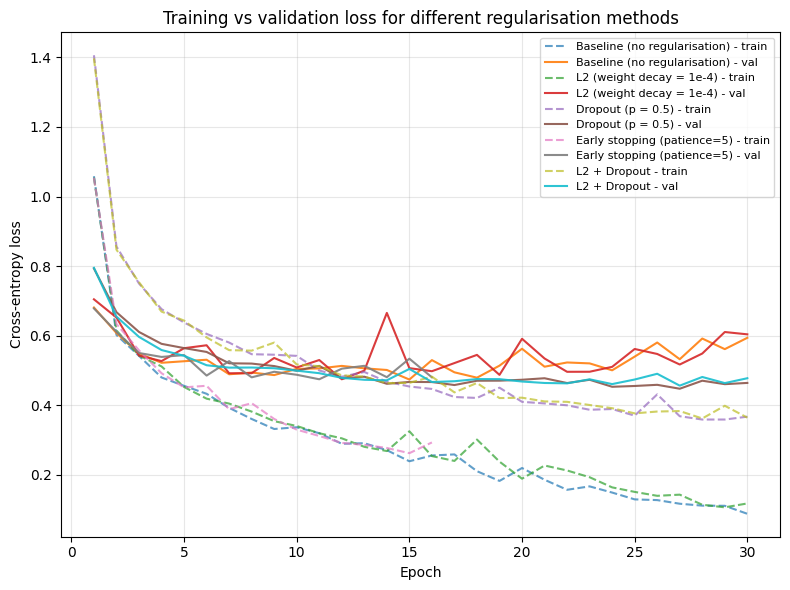

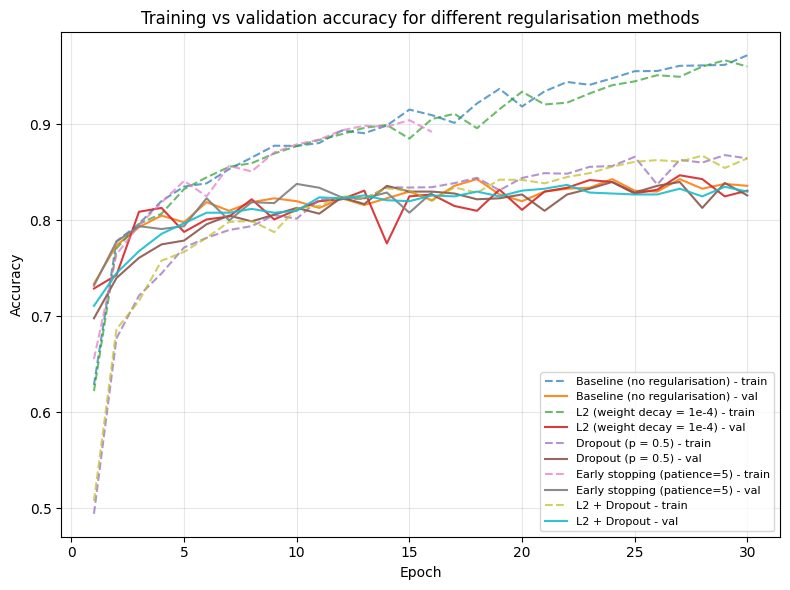

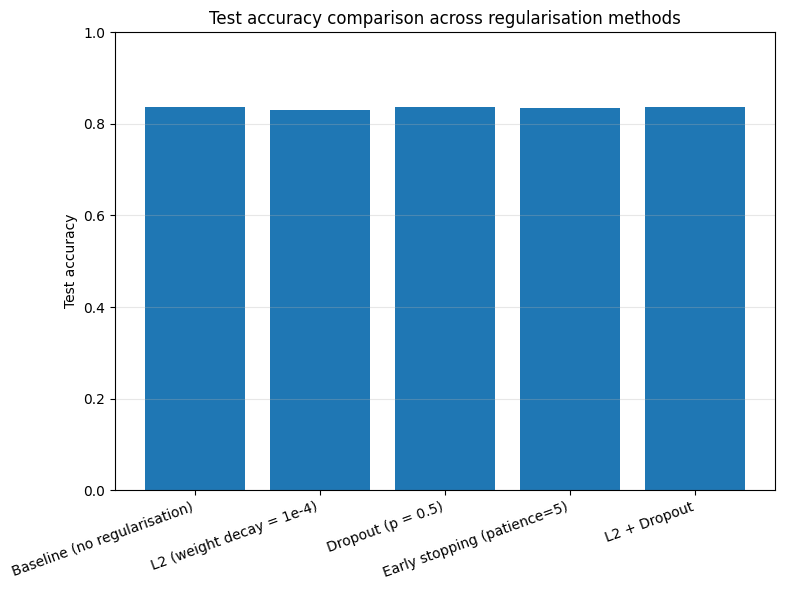

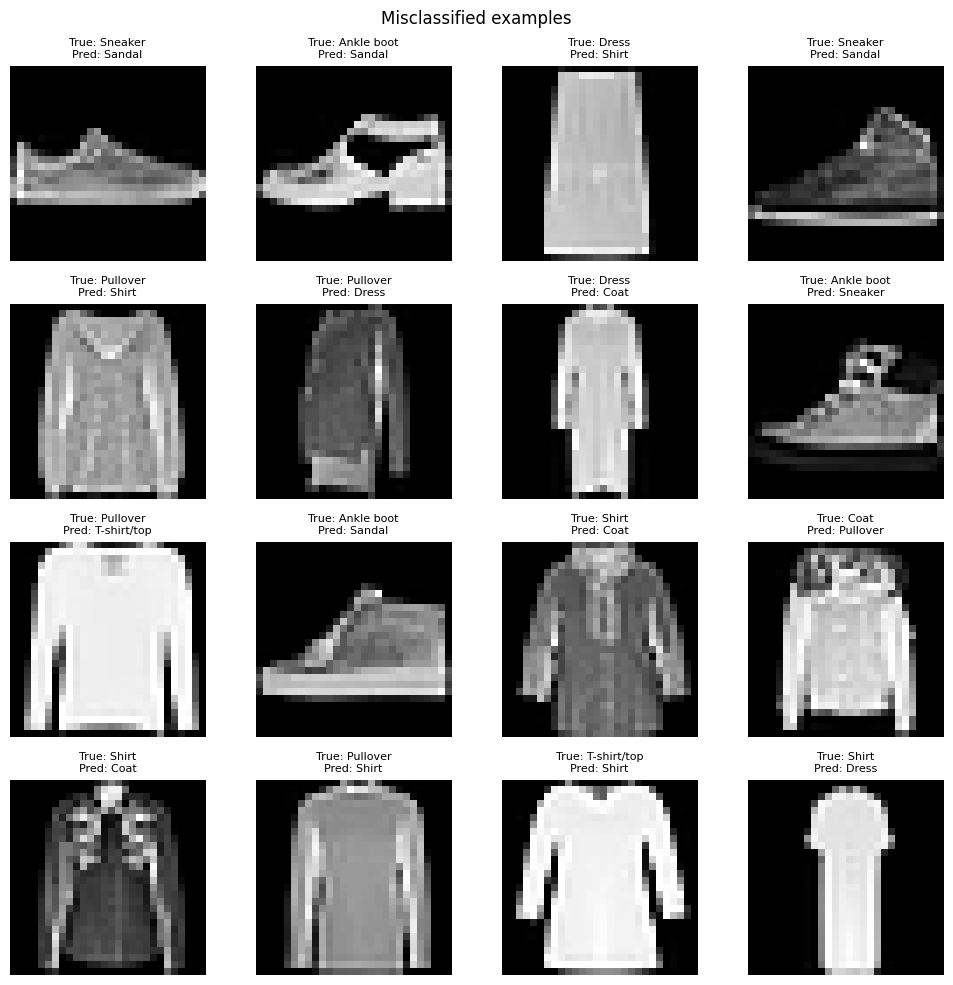

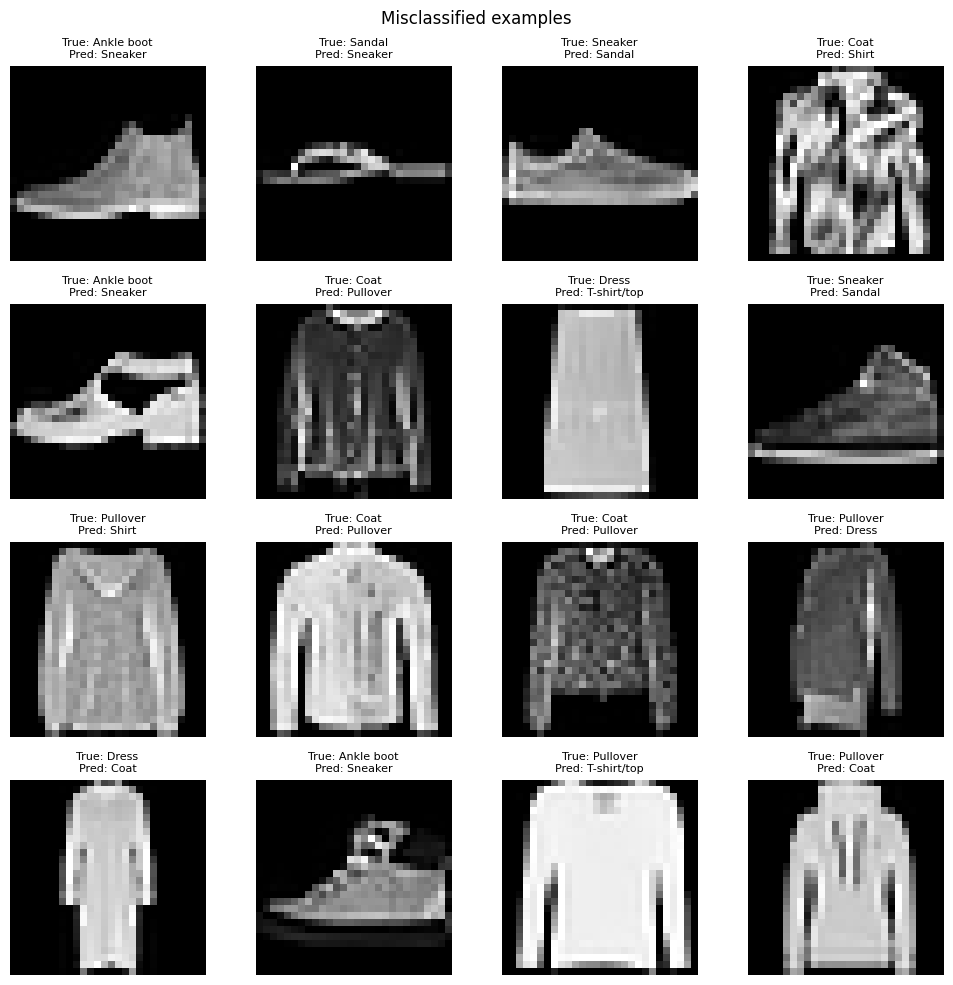


Summary of model performance:
Model                                 TrainAcc     ValAcc    TestAcc
Baseline (no regularisation)             0.972      0.836      0.837
L2 (weight decay = 1e-4)                 0.960      0.831      0.831
Dropout (p = 0.5)                        0.865      0.826      0.838
Early stopping (patience=5)              0.892      0.829      0.836
L2 + Dropout                             0.865      0.830      0.838

Figures saved in the 'figures' folder.


In [12]:
# Step 6: Plot training behaviour and summarise results
# -----------------------------------------------------
# In this cell we:
#  1) Define helper functions for plotting loss/accuracy curves
#  2) Generate and save the main figures for the tutorial
#  3) Visualise misclassified examples
#  4) Print a compact performance table


# 6.1 Plotting functions
# ----------------------

def plot_loss_curves(histories, save_path=None):
    """
    Plot training vs validation loss for each model configuration.
    This is one of the central figures for the tutorial.
    """
    plt.figure(figsize=(8, 6))
    for hist in histories:
        epochs = range(1, len(hist["train_loss"]) + 1)
        plt.plot(epochs, hist["train_loss"], linestyle="--", alpha=0.7,
                 label=f"{hist['name']} - train")
        plt.plot(epochs, hist["val_loss"], alpha=0.9,
                 label=f"{hist['name']} - val")

    plt.xlabel("Epoch")
    plt.ylabel("Cross-entropy loss")
    plt.title("Training vs validation loss for different regularisation methods")
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()


def plot_accuracy_curves(histories, save_path=None):
    """
    Plot training vs validation accuracy for each model configuration.
    This complements the loss plot and is also useful in the PDF.
    """
    plt.figure(figsize=(8, 6))
    for hist in histories:
        epochs = range(1, len(hist["train_acc"]) + 1)
        plt.plot(epochs, hist["train_acc"], linestyle="--", alpha=0.7,
                 label=f"{hist['name']} - train")
        plt.plot(epochs, hist["val_acc"], alpha=0.9,
                 label=f"{hist['name']} - val")

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs validation accuracy for different regularisation methods")
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()


def plot_test_accuracy_bar(histories, save_path=None):
    """
    Bar chart comparing test accuracy across all models.
    This gives a quick visual summary of which regularisation strategy worked best.
    """
    names = [h["name"] for h in histories]
    test_accs = [h["test_acc"] for h in histories]

    plt.figure(figsize=(8, 6))
    positions = np.arange(len(names))
    plt.bar(positions, test_accs)
    plt.xticks(positions, names, rotation=20, ha="right")
    plt.ylabel("Test accuracy")
    plt.ylim(0.0, 1.0)
    plt.title("Test accuracy comparison across regularisation methods")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()


# 6.2 Visualising misclassified examples
# --------------------------------------

@torch.no_grad()
def show_misclassified_examples(model, loader, class_names, max_images=16, save_path=None):
    """
    Show a small grid of misclassified test images for a given model.
    This is useful for qualitative insight in your tutorial.
    """
    model.eval()
    images = []
    preds_list = []
    targets_list = []

    for inputs, targets in loader:
        outputs = model(inputs.to(device))
        _, preds = outputs.max(1)
        preds = preds.cpu()
        mismatch = preds != targets
        if mismatch.any():
            for img, p, t in zip(inputs[mismatch], preds[mismatch], targets[mismatch]):
                images.append(img)
                preds_list.append(p.item())
                targets_list.append(t.item())
                if len(images) >= max_images:
                    break
        if len(images) >= max_images:
            break

    if not images:
        print("No misclassified examples found (unlikely).")
        return

    cols = 4
    rows = math.ceil(len(images) / cols)
    plt.figure(figsize=(2.5 * cols, 2.5 * rows))
    for idx, img in enumerate(images):
        plt.subplot(rows, cols, idx + 1)
        # Undo normalisation for display
        img = img * 0.5 + 0.5
        plt.imshow(img.squeeze(0), cmap="gray")
        plt.axis("off")
        plt.title(
            f"True: {class_names[targets_list[idx]]}\nPred: {class_names[preds_list[idx]]}",
            fontsize=8
        )

    plt.suptitle("Misclassified examples", fontsize=12)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()


# 6.3 Generate and save all key figures
# -------------------------------------

plot_loss_curves(all_histories, save_path="figures/loss_curves.png")
plot_accuracy_curves(all_histories, save_path="figures/accuracy_curves.png")
plot_test_accuracy_bar(all_histories, save_path="figures/test_accuracy_bar.png")

# Show misclassified examples for a couple of models:
baseline_model = trained_models["Baseline (no regularisation)"]
show_misclassified_examples(
    baseline_model,
    test_loader,
    class_names,
    max_images=16,
    save_path="figures/misclassified_baseline.png"
)

dropout_model = trained_models["Dropout (p = 0.5)"]
show_misclassified_examples(
    dropout_model,
    test_loader,
    class_names,
    max_images=16,
    save_path="figures/misclassified_dropout.png"
)

# 6.4 Print a compact summary table for all models
# ------------------------------------------------

print("\nSummary of model performance:")
print("{:<35s} {:>10s} {:>10s} {:>10s}".format(
    "Model", "TrainAcc", "ValAcc", "TestAcc"
))
for h in all_histories:
    name = h["name"]
    train_acc = h["train_acc"][-1]
    val_acc = h["val_acc"][-1]
    test_acc = h["test_acc"]
    print("{:<35s} {:>10.3f} {:>10.3f} {:>10.3f}".format(
        name, train_acc, val_acc, test_acc
))

print("\nFigures saved in the 'figures' folder.")
